<div style="background-color:	#41e5d3; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white">ML - Verhuuraantallen voorspellen</h1>
<b style="color:white">Jasper Duncker, Julia Boschman, Nima Agha Ghafar Hamedani</b>
    </div>

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

# metrics etc
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


### Bestanden importeren

In [24]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
Xtest = test.drop(['date_hour'],axis=1)
train

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163


### EDA

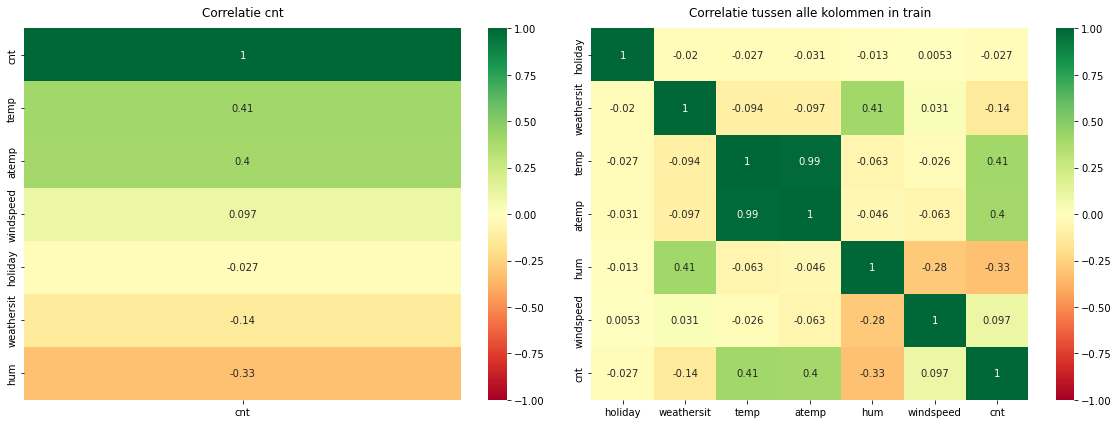

In [22]:
plt.figure(figsize=(16, 6))
plt.subplot(121)  
heatmap1 = sns.heatmap(train.corr(method='pearson')[['cnt']].sort_values(by='cnt', ascending=False),
                       vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap1.set_title('Correlatie cnt', fontdict={'fontsize': 12}, pad=12)


plt.subplot(122) 
heatmap2 = sns.heatmap(train.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap2.set_title('Correlatie tussen alle kolommen in train', fontdict={'fontsize': 12}, pad=12)

plt.tight_layout()  
plt.show()

### Metric Functie

In [8]:
def train_test_model(model):
    """
    Traint het opgegeven model met behulp van de meegeleverde trainingsgegevens en evalueert het met de testgegevens.

    Parameters:
    ----------
    model : model vergelijkbaar met sklearn
        Het model dat getraind en geëvalueerd moet worden.
    
    Returns:
    -------
    RMSE :
        Deze functie drukt de RMSE score van het model op de testgegevens af.
    
        
    """

    model.fit(X_train,y_train)
    y_pred= model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = MSE**0.5
    R2 = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    return print('R2:',R2,
                 '\nMAE:', MAE,
                 '\nMSE:',MSE,
                 '\nRMSE:',RMSE)

### Train, test, split

In [11]:
from sklearn.model_selection import train_test_split
X = train.drop(['date_hour','cnt'],axis=1)
y = train['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=27)

### LinearReg

In [21]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

train_test_model(lin_reg)
lin_reg_pred = lin_reg.predict(Xtest)


R2: 0.26574843016938676 
MAE: 115.33913243900095 
MSE: 23816.522099910337 
RMSE: 154.3260253486441


### Randomforest

### Pushen Kaggle

In [19]:
def push_dataframe(p_id_values, predictions_values, push=True, csv_file_path=None):
    """
    Creëert een DataFrame met kolommen 'p_id' en 'predictions' en slaat het op naar een CSV-bestand (optioneel).

    Args:
        p_id_values (list): Een lijst met waarden voor de 'p_id'-kolom.
        predictions_values (list): Een lijst met waarden voor de 'predictions'-kolom.
        push (bool): Een boolean die aangeeft of het DataFrame moet worden opgeslagen naar een CSV-bestand.
        csv_file_path (str): Het pad naar het CSV-bestand waarin het DataFrame moet worden opgeslagen (alleen nodig als push=True).

    Returns:
        pd.DataFrame: Een DataFrame met de opgegeven kolommen.
    """
    
    # Flatten the predictions_values array if it's 2D
    if len(predictions_values.shape) > 1:
        predictions_values = predictions_values.flatten()
        
    data = {'date_hour': p_id_values, 'cnt': predictions_values}
    df = pd.DataFrame(data)
    
    if push and csv_file_path:
        df.to_csv(csv_file_path, index=False)
        print(f"CSV file '{csv_file_path}' has been created.")
    
    return df

In [20]:
csv_file_path = r'C:\Users\nimaa\2023-2024\machine_learning\portfolio\Portfolio Deurwaardes\kaggle_sub\lin_reg_pred.csv'

#parameters
id_values = test['date_hour'] # niet veranderen
predictions_values = lin_reg_pred #predictions van model

# push functie toepassen
push_dataframe(id_values, predictions_values, push=True, csv_file_path=csv_file_path)

CSV file 'C:\Users\nimaa\2023-2024\machine_learning\portfolio\Portfolio Deurwaardes\kaggle_sub\lin_reg_pred.csv' has been created.


,date_hour,cnt
0,2012-12-01 00:00:00,47.597274
1,2012-12-01 01:00:00,47.597274
2,2012-12-01 02:00:00,54.376420
3,2012-12-01 03:00:00,49.224786
4,2012-12-01 04:00:00,45.748686
...,...,...
451,2012-12-19 19:00:00,190.899991
452,2012-12-19 20:00:00,149.103906
453,2012-12-19 21:00:00,125.979449
454,2012-12-19 22:00:00,131.131082
